[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1m2eNpBhrPOQlktV6bkeIz1Wd41625LW7?usp=sharing)

# Lab 1: Introduction to LangGraph - Basic Cake Shop Assistant

This notebook introduces the fundamentals of LangGraph by building a basic
cake shop assistant that can answer questions about cakes and provide recommendations.

In [1]:
!pip install -q langgraph langchain_openai gradio

In [2]:
from typing import Annotated, List, Dict, Any
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
import gradio as gr
import pandas as pd
import random
import os
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

In [3]:
os.makedirs('./data', exist_ok=True)
os.makedirs('./report', exist_ok=True)

In [4]:
import requests

links = [
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/Accessories.pdf', "name": "accessories"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/Cupcakes.pdf', "name": "cupcakes"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/Desserts.pdf', "name": "desserts"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/cakes.pdf', "name": "cakes"},

    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/cake_descriptions.csv', "name": "cake_table"}
]

for link in links:

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
    }

    response = requests.get(
        link["url"],
        headers=headers,
    )

    if link['name'] == "cake_table":
      _path = f"./data/{link['name']}.csv"
    else:
      _path = f"./data/{link['name']}.pdf"
    with open(_path, "wb") as f:
      f.write(response.content)

In [5]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("TT_OPENAI_KEY")

In [6]:
# Load cake data
cake_data = pd.read_csv("./data/cake_table.csv", encoding='cp1252')

In [7]:
cake_data.head(10)

,Name,Category,Ingredients,Description,Energy_kcal,Weight_grams,Restrictions,Delivery_time_hr,Available
0,Torta della Nonna Amore,G,"Ricotta, pine nuts, lemon zest, vanilla, sugar...",A nostalgic Tuscan-inspired cake with creamy r...,320,850,"Contains dairy, gluten, eggs",24,Yes
1,Festiva della Sicilia,G,"Almonds, citrus zest, mascarpone, candied oran...",A zesty almond cake with mascarpone frosting a...,360,900,"Contains nuts, dairy, eggs",24,Yes
2,Dubai Midnight Pistachio Fantasy,G,"Pistachios, rose syrup, cardamom, white chocol...",Lush green cake with exotic floral pistachio n...,420,1000,"Contains nuts, dairy",36,Yes
3,Ferrari Redline Fudge,G,"Dark chocolate, red glaze, fudge, espresso syrup",Dense chocolate fudge cake with red mirror gla...,450,950,"Contains dairy, caffeine",24,Yes
4,Goalpost Delight - Soccer Fan Cake,G,"Vanilla sponge, fondant, jam, whipped cream","Themed cake with stadium design, perfect for f...",390,1200,May contain artificial colors,24,Yes
5,Trophy Cake – Champions Edition,G,"Chocolate sponge, gold fondant, peanut butter ...","A tall, layered cake shaped like a trophy, wit...",460,1400,"Contains nuts, dairy, gluten",48,Yes
6,Birthday Blast Berry Bomb,G,"Mixed berries, vanilla sponge, cream cheese, c...","Fruity, colorful cake perfect for birthdays an...",380,1100,"Contains dairy, gluten, berries",24,Yes
7,ChocoCaramel Birthday Surprise,G,"Chocolate, caramel, fudge, popping candy",Rich chocolate with hidden caramel and surpris...,470,1200,"Contains milk, eggs, soy",24,Yes
8,Velvet Dream Cloud,G,"Vanilla sponge, mascarpone, white chocolate mo...","Fluffy, cloud-like cake with light, elegant cr...",350,1000,"Contains dairy, wheat",24,Yes
9,Hazelnut Toffee Crown,G,"Hazelnuts, caramel, praline, brown sugar sponge",Dense toffee cake with rich hazelnut flavor an...,480,1150,"Contains nuts, dairy, gluten",48,No


## Step 1: Define the State object

In LangGraph, we use a State object to maintain information between steps.
We'll use a Pydantic BaseModel with a messages field that uses the add_messages reducer.

In [8]:
class State(BaseModel):
    messages: Annotated[List[Any], add_messages]

## Step 2: Start the Graph Builder with our State class

In [9]:
graph_builder = StateGraph(State)

## Step 3: Create our Cake Assistant Node

Now we'll create a node that will process user messages and generate responses.
This node will use the OpenAI Chat model to generate responses about cakes.

In [10]:
# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o-mini")

def cake_assistant_node(state: State) -> Dict[str, Any]:
    """
    This function processes the current state and generates a response about cakes.
    """

    # Create a system message that includes information about the cake shop
    system_message = f"""
    You are an expert bakery assistant. Use the following context to answer the question.
    List all possible options for the user to pick from.

    {cake_data.head(10)}

    Please help customers by answering questions about our cakes, suggesting them
    based on their preferences, and explaining our ordering process.

    Always be friendly, helpful, and enthusiastic about our delicious cakes!
    """

    # Check if there's already a system message in the state
    found_system = False
    for msg in state.messages:
        if isinstance(msg, SystemMessage):
            msg.content = system_message
            found_system = True
            break

    # If no system message exists, add one
    if not found_system:
        state.messages = [SystemMessage(content=system_message)] + state.messages

    # Invoke the LLM
    response = llm.invoke(state.messages)

    # Return the updated state with the new message
    return {
        "messages": [response]
    }

# Add the node to our graph
graph_builder.add_node("cake_assistant", cake_assistant_node)

## Step 4: Create Edges

Now we'll define the flow of our graph by adding edges.
For this simple example, we'll go from START to our cake_assistant node, then to END.

In [11]:
graph_builder.add_edge(START, "cake_assistant")
graph_builder.add_edge("cake_assistant", END)

## Step 5: Compile the Graph

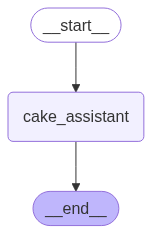

In [12]:
graph = graph_builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

## Step 6: Create the Chat Interface

Finally, we'll create a Gradio interface to interact with our cake assistant.

In [13]:
def process_message(user_input, history):
    """
    Process a user message and update the chat history.
    """
    # Create the initial state with the user message
    initial_state = State(messages=[HumanMessage(content=user_input)])

    # Invoke the graph with the initial state
    result = graph.invoke(initial_state)

    # Extract the assistant's response
    assistant_response = result["messages"][-1].content

    # Return the response for the Gradio interface
    return assistant_response

# Create and launch the chat interface
with gr.Blocks(theme=gr.themes.Soft(primary_hue="pink")) as demo:
    gr.Markdown("# 🍰 Sweet Algorithms Cake Shop Assistant")
    gr.Markdown("Ask me anything about our cakes, or tell me what flavors you like for recommendations!")

    chatbot = gr.ChatInterface(
        process_message,
        chatbot=gr.Chatbot(
            height=300,
            show_copy_button=True,
            bubble_full_width=False,
        ),
        title="Chat with our Cake Assistant",
    )

demo.launch()

<ipython-input-13-bbd3f0f6572f>:24: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot=gr.Chatbot(
<ipython-input-13-bbd3f0f6572f>:24: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  chatbot=gr.Chatbot(
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:321: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c235723f69c13e2fd1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Congratulations!

You've created your first LangGraph application for a business use case.
This simple cake shop assistant can help customers learn about cakes and
get recommendations based on their preferences.

In the next lab, we'll enhance this assistant by adding tools and memory
to make it more powerful and useful for the cake shop business.